In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# EDA: Data Understanding Steps

Get Description of data

In [ ]:
import chardet

with open('job_applicant_dataset.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [ ]:
df = pd.read_csv('job_applicant_dataset.csv',encoding='Windows-1252')

In [ ]:
import chardet

with open('job_applicant_dataset.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [ ]:
# get overall info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Applicant Name  10000 non-null  object
 1   Age                 10000 non-null  int64 
 2   Gender              10000 non-null  object
 3   Race                10000 non-null  object
 4   Ethnicity           10000 non-null  object
 5   Resume              10000 non-null  object
 6   Job Roles           10000 non-null  object
 7   Job Description     10000 non-null  object
 8   Best Match          10000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 703.3+ KB
None


In [ ]:
# basic statistics
print(df.describe(include='all'))

       Job Applicant Name           Age Gender             Race   Ethnicity  \
count               10000  10000.000000  10000            10000       10000   
unique                547           NaN      2                3          21   
top         Ashley Carter           NaN   Male  Mongoloid/Asian  Vietnamese   
freq                   45           NaN   5059             3355         506   
mean                  NaN     40.045200    NaN              NaN         NaN   
std                   NaN      8.950909    NaN              NaN         NaN   
min                   NaN     25.000000    NaN              NaN         NaN   
25%                   NaN     32.000000    NaN              NaN         NaN   
50%                   NaN     40.000000    NaN              NaN         NaN   
75%                   NaN     48.000000    NaN              NaN         NaN   
max                   NaN     55.000000    NaN              NaN         NaN   

                                                   

There are no missing (NaN) values in the dataset. So does not require imputation or removal of rows with missing data.

In [ ]:
# data type
print(df.dtypes)

Job Applicant Name    object
Age                    int64
Gender                object
Race                  object
Ethnicity             object
Resume                object
Job Roles             object
Job Description       object
Best Match             int64
dtype: object


## Understand Demographic Distribution

/tmp/ipython-input-1771456754.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Race', data=df, ax=axes[0, 1], palette='viridis',
/tmp/ipython-input-1771456754.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Ethnicity', data=df[df['Ethnicity'].isin(top_ethnicities.index)],
/tmp/ipython-input-1771456754.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Best Match', data=df, ax=axes[1, 1], palette='coolwarm')


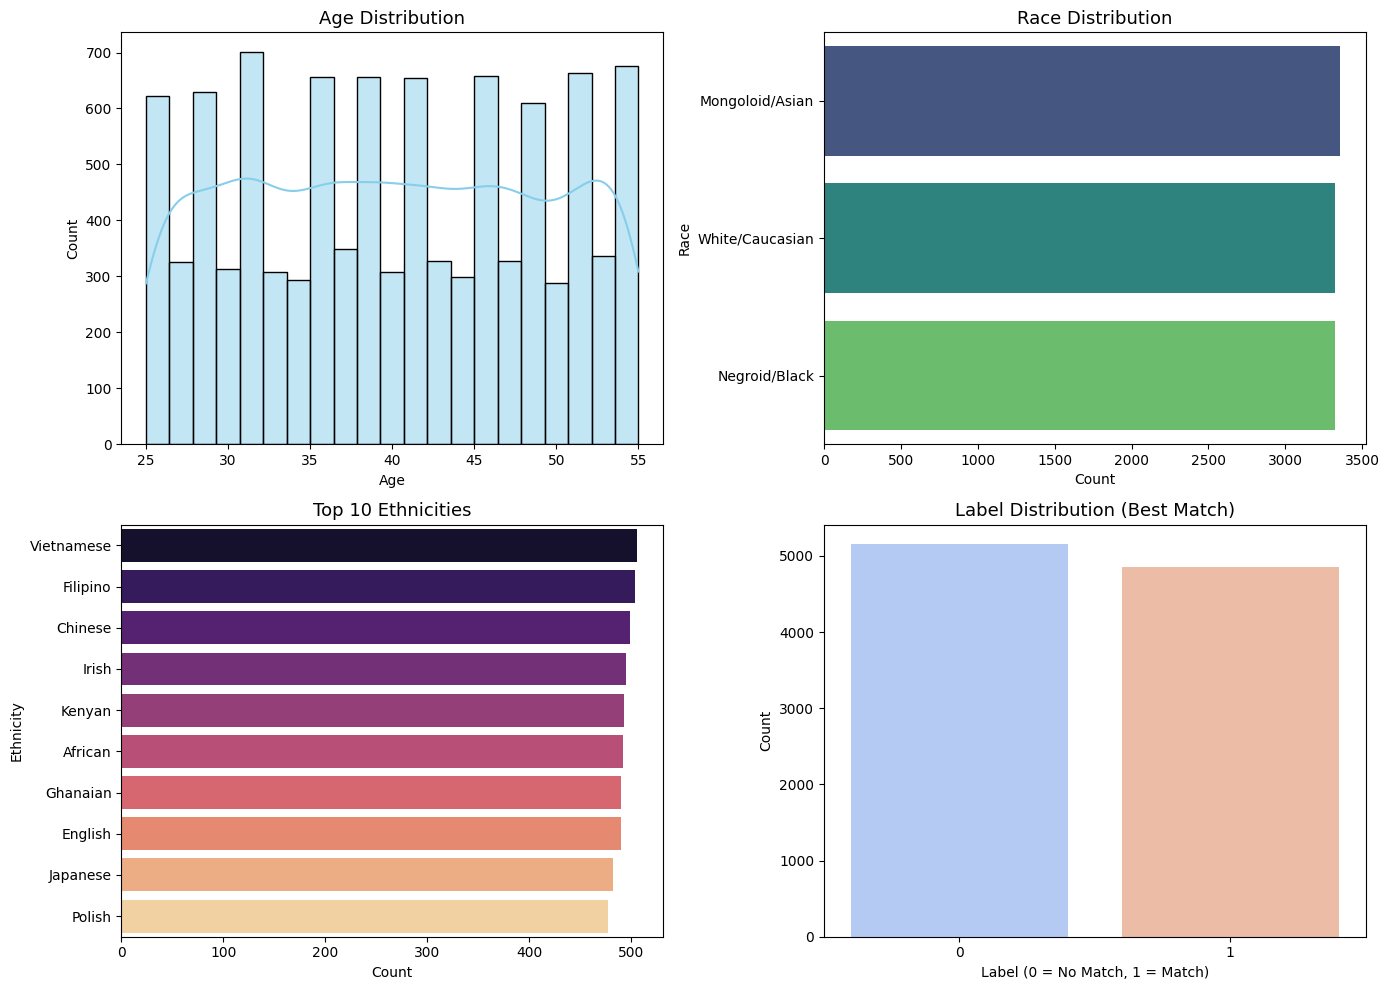

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# age
sns.histplot(df['Age'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Age Distribution", fontsize=13)
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Count")

# race
sns.countplot(y='Race', data=df, ax=axes[0, 1], palette='viridis',
              order=df['Race'].value_counts().index)
axes[0, 1].set_title("Race Distribution", fontsize=13)
axes[0, 1].set_xlabel("Count")
axes[0, 1].set_ylabel("Race")

# ethnicity
top_ethnicities = df['Ethnicity'].value_counts().head(10)  # top 10 for readability
sns.countplot(y='Ethnicity', data=df[df['Ethnicity'].isin(top_ethnicities.index)],
              ax=axes[1, 0], palette='magma',
              order=top_ethnicities.index)
axes[1, 0].set_title("Top 10 Ethnicities", fontsize=13)
axes[1, 0].set_xlabel("Count")
axes[1, 0].set_ylabel("Ethnicity")

# best match
sns.countplot(x='Best Match', data=df, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title("Label Distribution (Best Match)", fontsize=13)
axes[1, 1].set_xlabel("Label (0 = No Match, 1 = Match)")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


/tmp/ipython-input-285542365.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_counts.values, y=role_counts.index, palette="viridis")


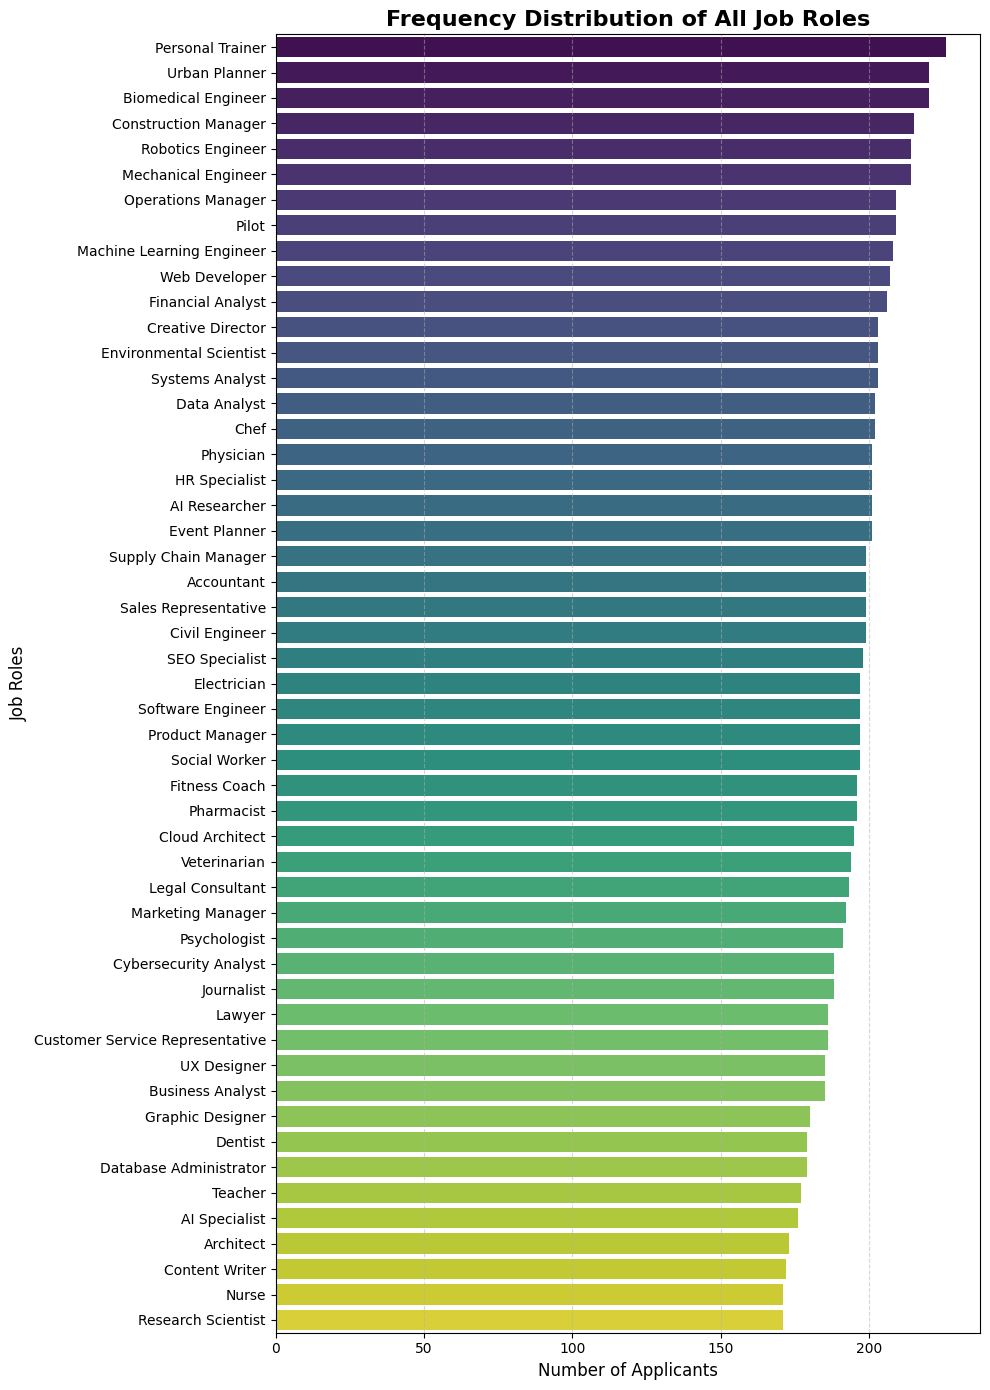

In [ ]:

# count occurrences of each job role
role_counts = df['Job Roles'].value_counts()

# create large vertical plot for all roles to be visible
plt.figure(figsize=(10, 14))
sns.barplot(x=role_counts.values, y=role_counts.index, palette="viridis")

plt.title("Frequency Distribution of All Job Roles", fontsize=16, weight='bold')
plt.xlabel("Number of Applicants", fontsize=12)
plt.ylabel("Job Roles", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Feature Correlation
Detect potential bias in dataset

/tmp/ipython-input-509759140.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='Best Match', data=df, ax=axes[0], palette='viridis')
/tmp/ipython-input-509759140.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Race', x='Best Match', data=df, ax=axes[1], palette='magma')
/tmp/ipython-input-509759140.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Best Match', y='Age', data=df, ax=axes[2], palette='coolwarm')


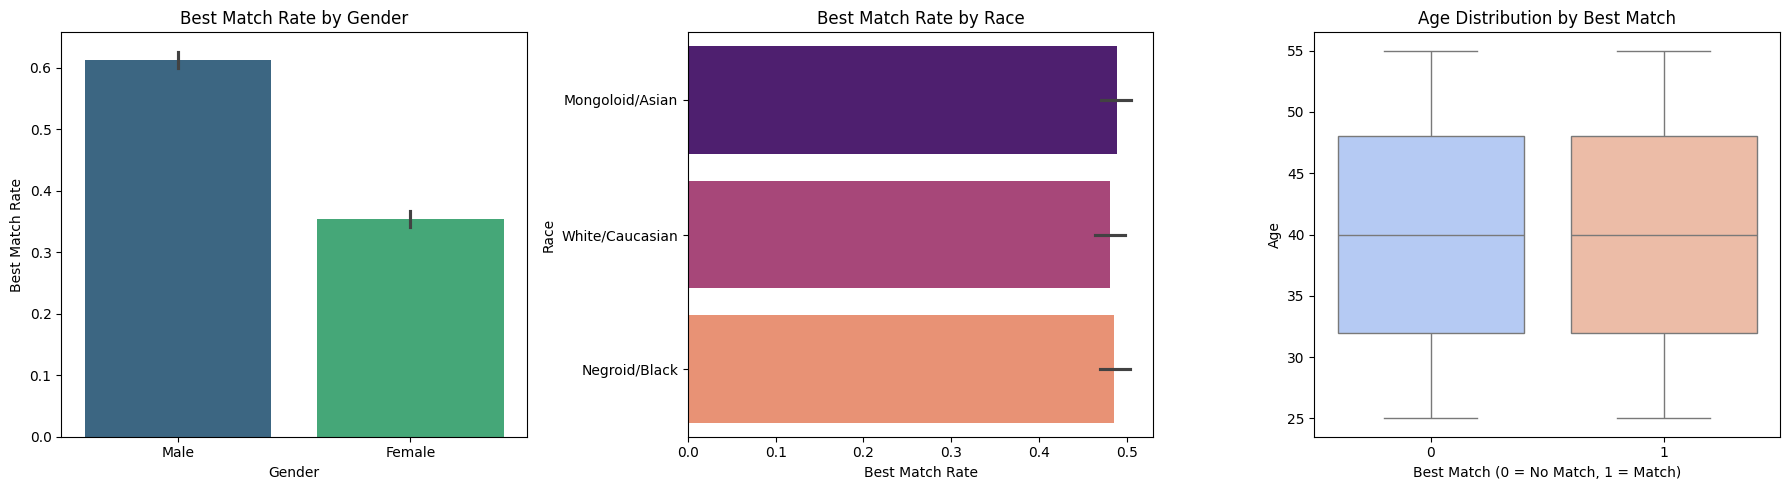

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender vs Best Match
sns.barplot(x='Gender', y='Best Match', data=df, ax=axes[0], palette='viridis')
axes[0].set_title("Best Match Rate by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Best Match Rate")

# Race vs Best Match
sns.barplot(y='Race', x='Best Match', data=df, ax=axes[1], palette='magma')
axes[1].set_title("Best Match Rate by Race")
axes[1].set_xlabel("Best Match Rate")
axes[1].set_ylabel("Race")

# Age vs Best Match
sns.boxplot(x='Best Match', y='Age', data=df, ax=axes[2], palette='coolwarm')
axes[2].set_title("Age Distribution by Best Match")
axes[2].set_xlabel("Best Match (0 = No Match, 1 = Match)")
axes[2].set_ylabel("Age")

plt.tight_layout()
plt.show()

The plots suggest some imbalance but no severe bias or outliers. Male applicants show a higher match rate than female applicants, because the dataset containing more male samples. Across races, the match rates are quite similar, indicating no major racial disparity in outcomes. The age distribution for matched and unmatched applicants is nearly identical, with no extreme outliers or skew, suggesting that age does not influence the matching process. Overall, the dataset appears balanced.

# Preprocessing

In [ ]:
# text cleaning
# remove punctuation, special symbols, and normalize casing.
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Resume_clean'] = df['Resume'].apply(clean_text)
df['JobDesc_clean'] = df['Job Description'].apply(clean_text)